In [34]:
from collections import namedtuple
import numpy as np
import scipy.integrate as it


Result = namedtuple('Result', ('nfev', 'cost', 'gradnorm', 'x'))
Result.__doc__ = """Результаты оптимизации

Attributes
----------
nfev : int
    Полное число вызовов модельной функции
cost : 1-d array
    Значения функции потерь 0.5 sum(y - f)^2 на каждом итерационном шаге.
    В случае метода Гаусса—Ньютона длина массива равна nfev, в случае ЛМ-метода
    длина массива — менее nfev
gradnorm : float
    Норма градиента на финальном итерационном шаге
x : 1-d array
    Финальное значение вектора, минимизирующего функцию потерь
"""

sq = lambda x : np.inner(x, x)



def f(z,h,w):
    funcunint = lambda x: 1 / np.sqrt(w + (1 - w) * (1 + x) ** 3)
    funcd = lambda q: 3e11/h*(1+q)*it.quad(funcunint, 0, q)[0]
    return (5 * np.log10(np.array(list([funcd(x) for x in z]))) - 5)


def j(z, h, w):
    func = lambda x: 1 / np.sqrt((1 - w) * (1 + x) ** 3 + w)
    integ = lambda q: it.quad(func,0,q)[0]
    d = np.array(list([integ(x) for x in z]))
    func2 = lambda x_2:  ((1 + x_2) ** 3 - 1) / (2 * (w + (1 - w) * (1 + x_2) ** 3) ** 1.5)
    dif = lambda z_1: it.quad(func2, 0, z_1)[0]
    j = np.empty((z.shape[0] , 2))
    j[:, 0] = -5 / (h*np.log(10))
    j[:, 1] = 5/np.log(10) * np.divide(np.array([dif(x) for x in z]), d)
    return j


def gauss_newton(y, f, j, x0, k=1, tol=1e-4, max_iters = 1000):
    x = np.asarray(x0, dtype = float)
    i = 0
    cost = []
    while True:
        i += 1
        jac = j(*x)
        r = f(*x)-y
        cost.append(0.5 * sq(r))
        grad = jac.T @ r
        gradn = np.sqrt(sq(grad))
        delta = np.linalg.solve(sq(jac.T), -grad)
        x = x + k * delta
        if i == max_iters:
            break
        if i <= 2:
            continue
        if np.abs(cost[-2] - cost[-1]) / cost[-1] <= tol:
            break
    return Result(nfev = i, cost = cost, gradnorm = gradn, x = x)


def lm(y, f, j, x0, lmbd0=1e-2, nu=2, tol=1e-4,max_iters=1000):
    x = np.asarray(x0, dtype=float)
    i = 0
    cost = []
    while True:
        i += 1
        jac = j(*x)
        r = f(*x) - y
        cost.append(0.5 * sq(r))
        grad = jac.T @ r
        gradn = np.sqrt(sq(grad))
        a = sq(jac.T)
        delta_l = np.linalg.solve(lmbd0 * np.eye(a.shape[0]) + a, - grad)
        f_l = 0.5 * sq(f(*(x + delta_l)) - y)
        delta_nu = np.linalg.solve(lmbd0 * np.eye(a.shape[0])/ nu + a, - grad)
        f_nu = 0.5 * sq(f(*(x + delta_nu)) - y)
        if f_nu <= cost[-1]:
            lmbd0 = lmbd0 / nu
            x += delta_nu
        elif (f_nu > cost[-1]) and (f_l <= cost[-1]):
            x += delta_l
        else:
            n = nu ** (1 / (nu*10))
            lmbd0 = lmbd0 * n
            delta_n = np.linalg.solve(lmbd0 * np.eye(a.shape[0]) + a, - grad)
            f_n = 0.5 * sq(f(*(x + delta_n)) - y)
            while f_n > cost[-1]:
                lmbd0 = lmbd0 * n
                delta_n = np.linalg.solve(lmbd0 * np.eye(a.shape[0]) + a, - grad)
                f_n = 0.5 * sq(f(*(x + delta_n)) - y)
            x = x + delta_n
        if i == max_iters:
            break
        if i <= 2:
            continue
        if np.abs(cost[-1] - cost[-2]) <= tol * cost[-1]:
            break
    return Result(nfev = i, cost = cost, gradnorm = gradn, x = x)
 

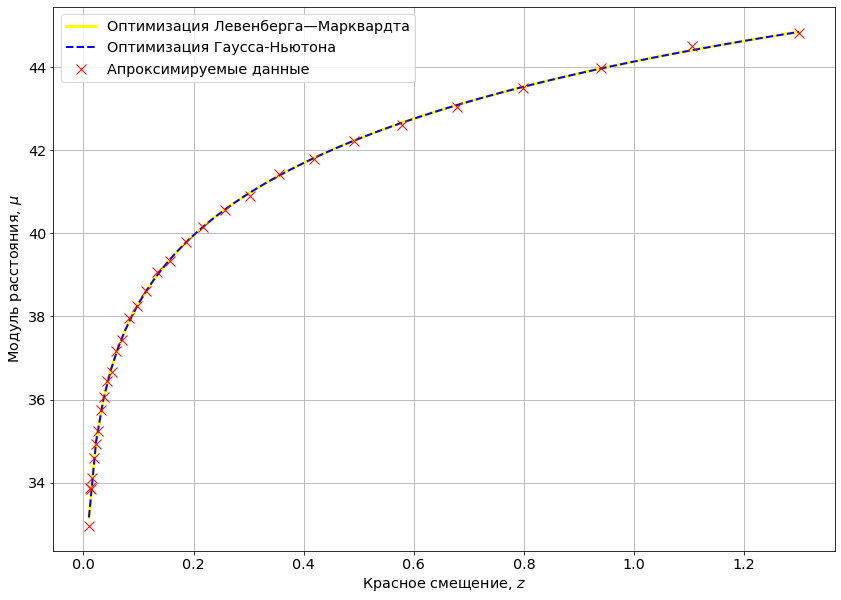

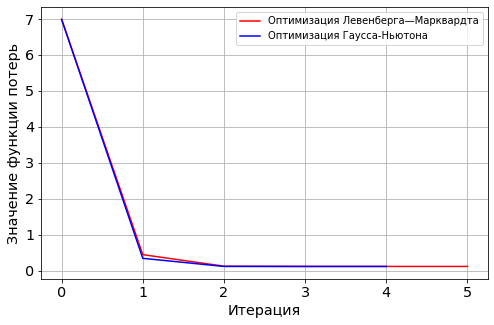

In [35]:
from opt import gauss_newton, lm
import numpy as np
import matplotlib.pyplot as plt
import json

if __name__ == "__main__":
    data = np.genfromtxt('/Users/vlad/Downloads/jla_mub.txt',dtype = float, names = ['z','mu'])
    x0 = np.array([50, 0.5])
    xx = np.linspace(0.01, 1.3, 100)
    rlm = lm(data['mu'], lambda *args: f(data['z'], *args),lambda *args: j(data['z'],*args), x0)
    x0 = np.array([50, 0.5])
    rgn = gauss_newton(data['mu'],lambda *args:f(data['z'],*args),lambda *args: j(data['z'],*args),x0)
    x0 = np.array([50, 0.5])
    plt.figure(figsize=(14, 10))
    plt.xticks(fontsize='x-large')
    plt.yticks(fontsize='x-large')
    plt.grid()
    plt.xlabel("Красное смещение, $z$", fontsize='x-large')
    plt.ylabel("Модуль расстояния, $\mu$", fontsize='x-large')
    plt.plot(xx ,f(xx, *rlm.x), lw=3,  color = 'yellow', label= 'Оптимизация Левенбергa—Марквардтa')
    plt.plot(xx ,f(xx, *rgn.x),'--' , lw=2, color = 'b', label = 'Оптимизация Гаусса-Ньютона')
    plt.plot(data['z'], data['mu'], 'x', color = 'r', ms= 10, label = 'Апроксимируемые данные')
    plt.legend(loc='upper left' , fontsize='x-large')
    plt.savefig('mu-z.png')
    plt.figure(figsize=(8, 5))
    plt.xticks(range(rlm.nfev), fontsize='x-large')
    plt.yticks(fontsize='x-large')
    plt.grid()
    plt.xlabel("Итерация", fontsize='x-large')
    plt.ylabel("Значение функции потерь", fontsize='x-large')
    plt.plot(range(rlm.nfev), rlm.cost,color = 'r', label='Оптимизация Левенбергa—Марквардтa')
    plt.plot(range(rgn.nfev), rgn.cost,color = 'b', label='Оптимизация Гаусса-Ньютона')
    plt.legend()
    plt.savefig('cost.png')  
    d = {
        "Gauss-Newton": {"H0": round(rgn.x[0]), "Omega": round(rgn.x[1], 2), "nfev": rgn.nfev},
        "Levenberg-Marquardt": {"H0": round(rlm.x[0]), "Omega": round(rlm.x[1], 2), "nfev": rlm.nfev}
        }
    with open('parameters.json', 'w') as f:
        json.dump(d, f)
